**Selection of type of autoencoder model and noise type:**

Change the variable NOISE_TYPE before running to change the noise type



**List of noise types:**
1. Gaussian Noise 
2. Salt Pepper Noise
3. Gaussian Blur
4. Speckle Noise
5. Random Noise
6. Laplacian Noise
7. Multiplicative Gaussian Noise
8. Impulse Noise
9. Uniform Noise


In [1]:
NOISE_TYPE=1

In [2]:
import matplotlib.pyplot as plt
import random,cv2,pickle
from keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, MaxPooling2D, Conv2D, Activation,Conv2D, Input, UpSampling2D,ActivityRegularization
import numpy as np 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from os import listdir
from wand.image import Image
NOISE_TYPE-=1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
L=148
W=212

In [4]:
def get_img(path):
  path = path.strip()
  img = cv2.imread(path)
  img  = cv2.resize(img, (L, W))
  return img

def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()
def cnn_ae():
    x = Input(shape=(W, L, 3)) 

    # Encoder
    e_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
    batchnorm_1 = BatchNormalization()(pool1)
    e_conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(batchnorm_1)
    pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
    batchnorm_2 = BatchNormalization()(pool2)
    e_conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(batchnorm_2)
    pool3 = MaxPooling2D((2, 2), padding='same')(e_conv3)
    batchnorm_3 = BatchNormalization()(pool3)
    e_conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_3)
    h = MaxPooling2D((2, 2), padding='same')(e_conv4)


    # Decoder
    d_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(h)
    up1 = UpSampling2D((2, 2))(d_conv1)
    d_conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(d_conv2)
    d_conv3 = Conv2D(64, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2, 2))(d_conv3)
    d_conv4 = Conv2D(32, (3, 3), activation='relu')(up3)
    up4 = UpSampling2D((2, 2))(d_conv4)
    r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)

    model = Model(x, r)
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model


def create_model():
    return cnn_ae

In [5]:
mypath='/kaggle/input/ai-btech/formated_muzzle_data/training/'
folders = [ f for f in listdir(mypath)]
filelocs=[]
for i in folders:
    x=mypath+i+"/"
    for j in listdir(x):
        filelocs.append(x+j)
images=[]
for name in tqdm(filelocs):
  images.append(get_img(name))
images=np.array(images,dtype=np.uint8)
train_data, test_data = train_test_split(images, test_size=0.1, random_state=0, shuffle=True)
images=[]

100%|██████████| 2947/2947 [00:46<00:00, 62.82it/s] 


In [6]:
#Functions to add noise to dataset
# Since kaggle doesnt provide enough RAM to be able to run with all different types of noises(Not to be included in report or presentation) hence seperate fresh runs needs to be done for all noises
# Changing the type number changes the type of noise
def laplacian_noise(data):
    with Image.from_array(data) as img:
        img.noise("laplacian",attenuate=0.9)
        return np.array(img)
def multiplicative_gaussian_noise(data):
    with Image.from_array(data) as img:
        img.noise("multiplicative_gaussian",attenuate=0.9)
        return np.array(img)
def impulse_noise(data):
    with Image.from_array(data) as img:
        img.noise("impulse",attenuate=0.9)
        return np.array(img)
def uniform_noise(data):
    with Image.from_array(data) as img:
        img.noise("uniform",attenuate=0.9)
        return np.array(img)
def random_noise(data):
    with Image.from_array(data) as img:
        img.noise("random",attenuate=0.9)
        return np.array(img)
def speckle_noise(data):
    row,col,channel=data.shape
    return ((np.random.randn(row,col,channel).reshape(row,col,channel))*data)
def poisson_noise(data):
    vals=len(np.unique(data))
    vals=2**(np.ceil(np.log2(vals)))
    noisy=np.random.poisson(data*vals)/float(vals)
    return noisy
def gaussian_noise(data):
    mean = (10, 10, 10)
    std = (50, 50, 50)
    row, col, channel = data.shape
    noise = np.random.normal(mean, std, (row, col,channel)).astype('uint8')
    return data + noise
def salt_pepper_noise(data, p=0.3):
  rows, columns, channels = data.shape
  output = np.zeros(data.shape, np.uint8)
  for i in range(rows):
    for j in range(columns):
      r = np.random.random()
      if r < p/2:
        output[i][j] = [0, 0, 0]
      elif r > p/2 and r <= p:
        output[i][j] = [255, 255, 255]
      else:
        output[i][j] = data[i][j]
  return output
def gaussian_blur(data):
  dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
  return dst
def add_noise_to_dataset(data):
    count = 0
    end = len(data)
    output_data = []
    noise_type=NOISE_TYPE
    noise_functions=[gaussian_noise, salt_pepper_noise,gaussian_blur,speckle_noise,poisson_noise,laplacian_noise,multiplicative_gaussian_noise,impulse_noise,uniform_noise,random_noise]
    for count in tqdm(range(end)):
        output_data.append(noise_functions[noise_type](data[count]))
    return np.array(output_data)

In [7]:
noisy_train_data = add_noise_to_dataset(train_data)
noisy_test_data = add_noise_to_dataset(test_data)
train_data = train_data / 255.0
test_data = test_data / 255.0
noisy_train_data = noisy_train_data / 255.0 
noisy_test_data = noisy_test_data / 255.0 

100%|██████████| 295/295 [00:01<00:00, 209.90it/s]


In [8]:
auto_encoder = (create_model())()
auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 212, 148, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 212, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 74, 128)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 106, 74, 128)     512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 74, 128)      147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 37, 128)      0     

In [9]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 20.2 MB/s eta 0:00:00a 0:00:01


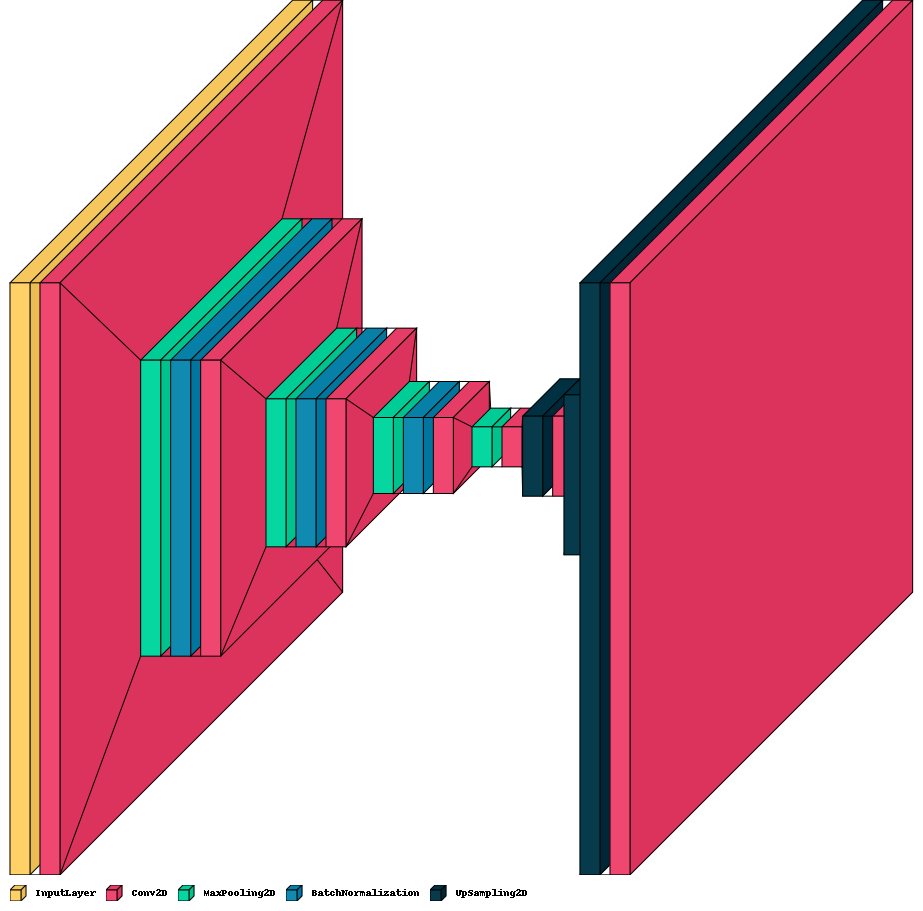

In [10]:
import visualkeras
visualkeras.layered_view(auto_encoder,legend=True)

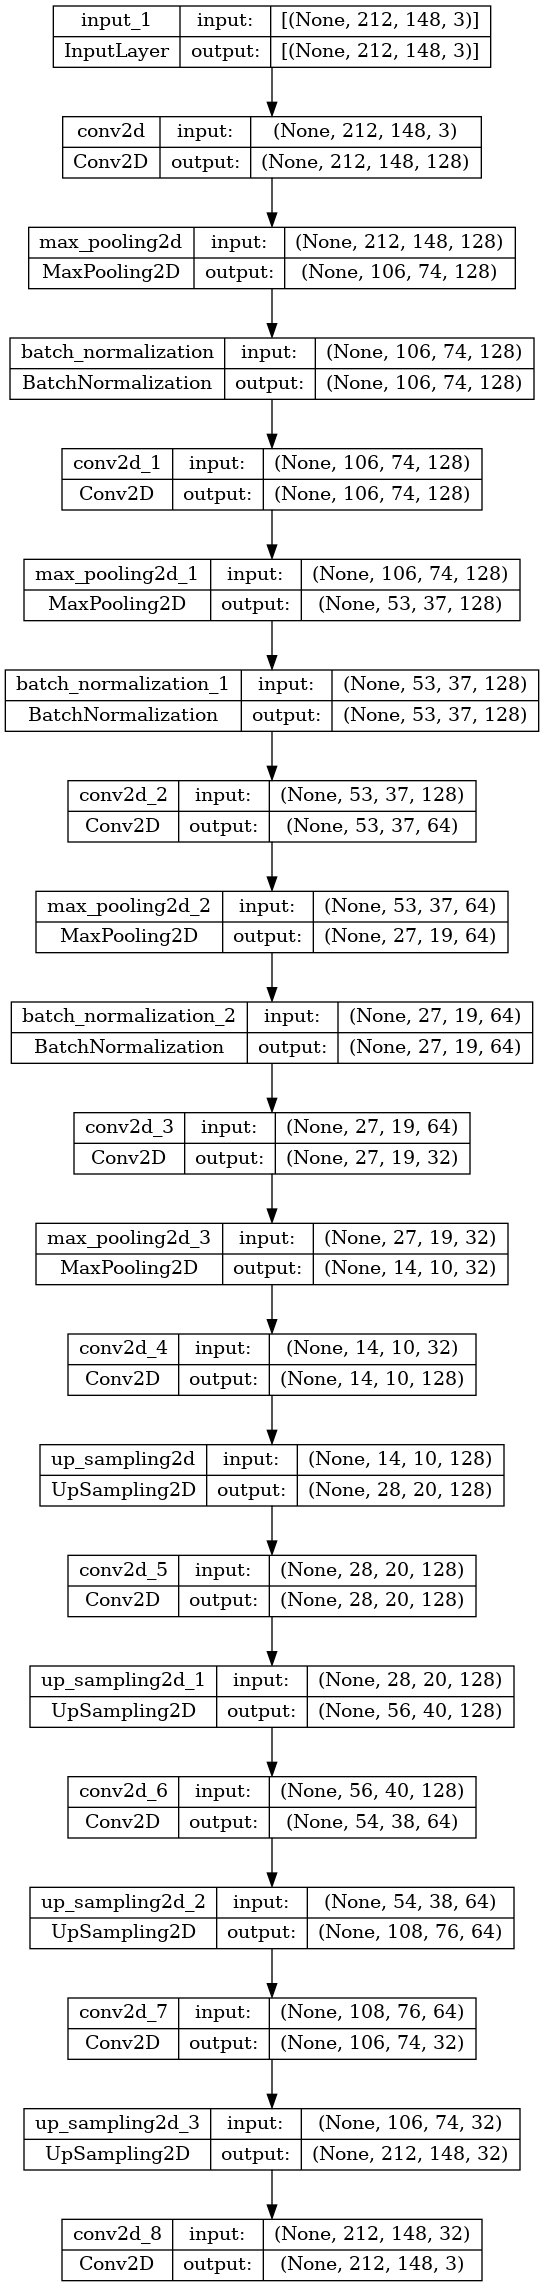

In [11]:
plot_model(auto_encoder, show_shapes=True, show_layer_names=True,to_file='file.png')

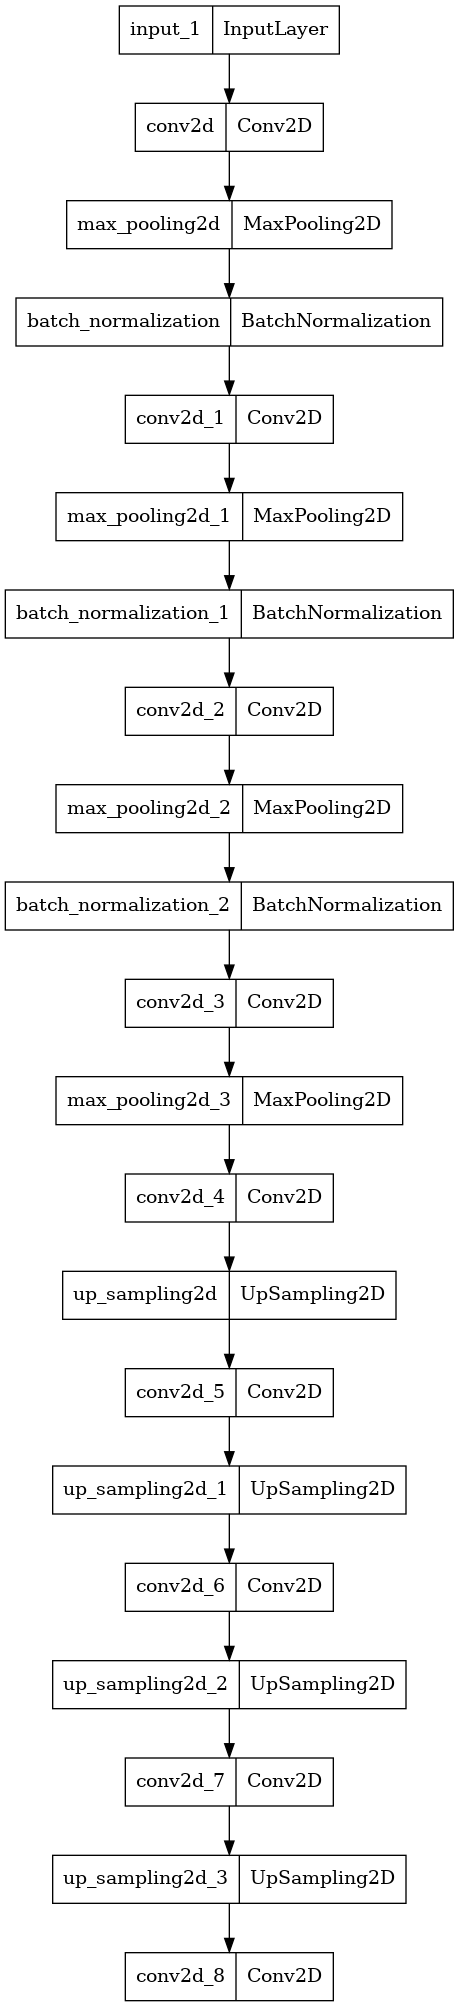

In [12]:
plot_model(auto_encoder,to_file='file1.png')

In [ ]:
history = auto_encoder.fit(noisy_train_data, train_data, epochs=500, batch_size=32,validation_data=(noisy_test_data,test_data),callbacks=EarlyStopping(monitor='val_loss',verbose=1,patience=80))

Epoch 1/500


In [ ]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Epochs on Training loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.title('Epochs on Training accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
result=auto_encoder.predict(noisy_train_data[0:5])

In [ ]:
plot_rgb_img(result[0])

In [ ]:
x=noisy_train_data[0:5]

In [ ]:
plt.imshow(x[0])

In [ ]:
plt.imshow(train_data[0])

In [ ]:
predictions=auto_encoder.predict(noisy_test_data)

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
from math import log10, sqrt

psnr = [PSNR(test_data[i], auto_encoder.predict(np.array([noisy_test_data[i]]))) for i in range(len(test_data))]

In [ ]:
# Plot PSNR vs Index
plt.plot(psnr, label='PSNR')
plt.title('PSNR vs Index')
plt.xlabel('Index')
plt.ylabel('PSNR')
plt.legend()
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

ssim_values = []

for i in range(len(noisy_test_data)):
    s = ssim((test_data[i]).astype(np.uint8), (predictions[i]*255).astype(np.uint8), channel_axis=2)
    ssim_values.append(s)

plt.plot(ssim_values)
plt.title('SSIM vs Index')
plt.xlabel('Image index')
plt.ylabel('SSIM')
plt.show()